In [2]:
# import diffeq_2 as methods
from scipy.integrate import odeint
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft, signal, linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import pandas as pd
# sns.set_theme()

import diffeq_tsint as methods


In [3]:
from pylab import rcParams
import mplcyberpunk
plt.style.use("cyberpunk")

# plt.style.use('ggplot')
rcParams['figure.figsize'] = 8, 5
rcParams['font.family'] = 'Pacifico'


## Fourierova metoda

In [4]:
def gauss(x, sigma):
    return np.exp(-x**2/(2*sigma**2))


def roll_middle(arr):
    return np.roll(arr, int(len(arr)/2))


Za rešitev Fourierove metode je več načinov. Najbolj splošen je seveda, da funkcijo prezrcalimo liho ali sodo potem pa nardimo Fourierovo transformacijo in se poskušamo znebiti aliasinga. To nam zna precej zmešati štreme. Po nekaj poskusov implementacije z FFT sem ugotovil, da je čisto isto, če vzamemo za Periodične pogoje diskretno kosinusno transformacijo (fft.DCT) za homogene Dirichletove pogoje pa zgolj naredimo sinusno transformacijo (fft.DST), ki nam prisili, da bo robni pogoj enak 0. Tako je koda za obe metode praktično enaka, zgolj zamenjamo vrstico kode. Vredno je povdariti še, da se je integracija bolj smiselna z ODEINT kot z Eulerjevo metodo.

### Periodični

In [5]:
def periodini_robni(Nt, tk, x, T_0, D, name='', title=''):
    Nt = 100
    c_k = fft.dct((T_0))
    t = np.linspace(0, tk, Nt)
    D = 1

    def homogeneous_dirichlet(y, t):
        return D*(-4*np.pi**2 * (np.arange(len(y))/(x2-x1))**2)*y

    c_kt = odeint(homogeneous_dirichlet, c_k.real, t)
    T_t = fft.idct(c_kt).real
    cmap = plt.get_cmap('cool', len(T_t))
    fig, axes = plt.subplots(ncols=1, figsize=(8, 4))
    ax0 = axes

    for i in range(len(T_t)):
        plt.plot(x, (T_t[i]), c=cmap(i))
    norm = mpl.colors.Normalize(vmin=t[0], vmax=t[-1])
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.xlabel(r'$x$')
    plt.ylabel('T')
    plt.title("Časovni razvoj gausovke, periodični robni pogoj")
    fig.colorbar(sm, ax=axes, label=r't')

    if title:
        plt.title(title)
    else:
        plt.title("Časovni razvoj gausovke, homogeni robni pogoj")

    # mplcyberpunk.make_lines_glow()
    plt.savefig(f"grafi/periodicni_robni_{tk}_{name}.pdf", bbox_inches='tight')
    plt.show()


Treba je še poiskati neke primerne brezdimenzijske parametre. Naš cilj je zgolj ugotoviti kakšno je obnašanje, zato poiščem parametre, da bodo grafi zgledni. Recimo, da je kar $D = 1$ ter območje od -2 do 2. Da bo gausovka v takem območju primerna lahko vzamemo $\sigma = 0.5$.

findfont: Font family ['Pacifico'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Pacifico'] not found. Falling back to DejaVu Sans.


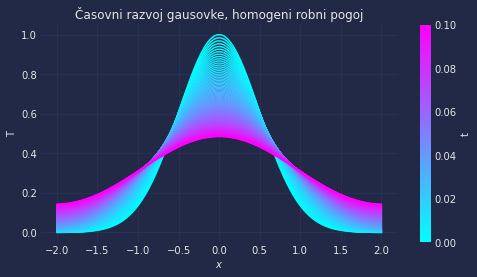

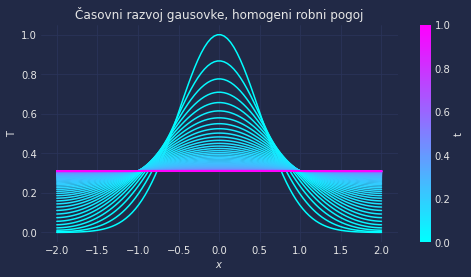

In [6]:
Nx = 100
x1, x2 = -2, 2
x = np.linspace(x1, x2, Nx)
sigma = 0.5

periodini_robni(100, 0.1, x, gauss(x, sigma), 1)

periodini_robni(100, 1, x, gauss(x, sigma), 1)
# periodini_robni(100, 1, x, gauss(x, 10), 1)


### Neperiodicni / homogen

In [7]:
def homogeni_robni(Nt, tk, x, T_0, D, name='', title=''):
    Nt = 100
    c_k = fft.dst((T_0))
    t = np.linspace(0, tk, Nt)
    D = 1

    def homogeneous_dirichlet(y, t):
        return D*(-4*np.pi**2 * (np.arange(len(y))/(x2-x1))**2)*y

    c_kt = odeint(homogeneous_dirichlet, c_k.real, t)
    T_t = fft.idst(c_kt).real
    cmap = plt.get_cmap('cool', len(T_t))
    fig, axes = plt.subplots(ncols=1, figsize=(8, 4))
    ax0 = axes

    for i in range(len(T_t)):
        plt.plot(x, (T_t[i]), c=cmap(i))
    norm = mpl.colors.Normalize(vmin=t[0], vmax=t[-1])
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.xlabel(r'$x$')
    plt.ylabel('T')

    if title:
        plt.title(title)
    else:
        plt.title("Časovni razvoj gausovke, homogeni robni pogoj")
        
    fig.colorbar(sm, ax=axes, label=r't')

    plt.savefig(f"grafi/homogeni_robni_{tk}_{name}.pdf", bbox_inches='tight')
    plt.show()


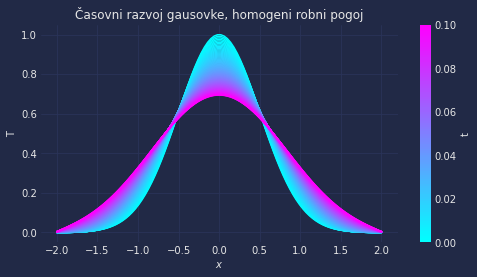

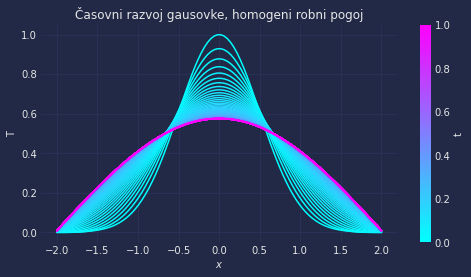

In [8]:
Nx = 100
x1, x2 = -2, 2
x = np.linspace(x1, x2, Nx)
sigma = 0.5

homogeni_robni(100, 0.1, x, gauss(x, sigma), 1)
homogeni_robni(100, 1, x, gauss(x, sigma), 1)


### Dodatna, začetni sinus

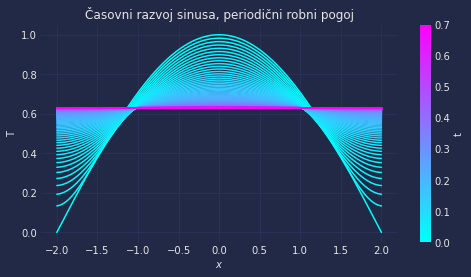

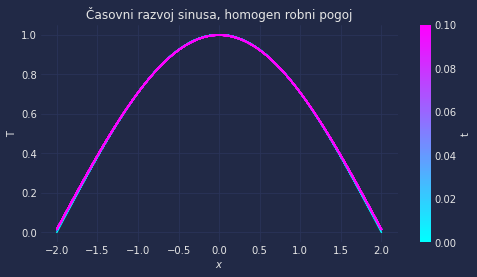

In [15]:
Nx = 100
x1, x2 = -2, 2
a = x2-x1
x = np.linspace(x1, x2, Nx)
sigma = 0.5

T0 = np.sin((x-x1)/a*np.pi)
T20 = np.sin((x-x1)/a*2*np.pi)
# plt.plot(x, T0)

# periodini_robni(100, 2, x, T20, 1)
periodini_robni(100, 0.7, x, T0, 1, name="sinus", title='Časovni razvoj sinusa, periodični robni pogoj')

# homogeni_robni(100, 2, x, T20, 1)
homogeni_robni(100, 0.1, x, T0, 1, name="sinus",
               title='Časovni razvoj sinusa, homogen robni pogoj')

# periodini_robni(100, 1, x, gauss(x, sigma), 1)
# periodini_robni(100, 1, x, gauss(x, 10), 1)


Razvoj sinusnega robnega pogoja je precje trivialen proces, posebej ko imamo že narejene funkcije. Tako samo namesto gausovke izračunamo sinus in izračunamo časovni razvoj.

## Kolokacijska metoda

In [10]:
def B_splines(x, xk, k, delta_x):
    # delta_x = xk[1] - xk[0]
    if x <= xk[k-2]:
        return 0
    elif x <= xk[k-1]:
        return (x - xk[k-2])**3 / delta_x**3
    elif x <= xk[k]:
        return (x - xk[k-2])**3 / delta_x**3 - 4 * (x - xk[k-1])**3 / delta_x**3
    elif x <= xk[k+1]:
        return (xk[k+2] - x)**3 / delta_x**3 - 4 * (xk[k+1] - x)**3 / delta_x**3
    elif x <= xk[k+2]:
        return (xk[k+2] - x)**3 / delta_x**3
    return 0


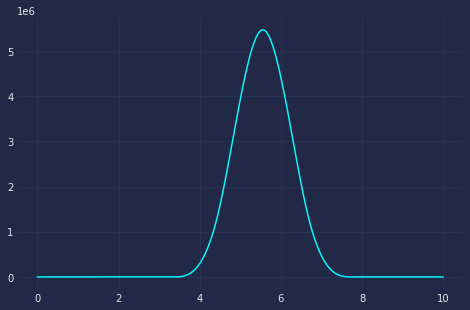

In [11]:
xk = np.linspace(0, 10, 10)
x = np.linspace(0, 10, 1000)

B_splines_vec = np.vectorize(lambda z, k: B_splines(z, xk, k, x[1] - x[0]))
yk = B_splines_vec(x, 5)

plt.plot(x, yk)


In [12]:
def tridiag(i, j, a, b, c):
    if i == j:
        return a
    elif i+1 == j:
        return b
    elif i-1 == j:
        return c
    return 0


def A_ij(i, j): return tridiag(i, j, 4, 1, 1)
def B_ij(i, j): return tridiag(i, j, -2, 1, 1)


N = 100
A = np.fromfunction(np.vectorize(A_ij), (N, N))
B = np.fromfunction(np.vectorize(B_ij), (N, N))
A, B


(array([[4, 1, 0, ..., 0, 0, 0],
        [1, 4, 1, ..., 0, 0, 0],
        [0, 1, 4, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 4, 1, 0],
        [0, 0, 0, ..., 1, 4, 1],
        [0, 0, 0, ..., 0, 1, 4]]),
 array([[-2,  1,  0, ...,  0,  0,  0],
        [ 1, -2,  1, ...,  0,  0,  0],
        [ 0,  1, -2, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., -2,  1,  0],
        [ 0,  0,  0, ...,  1, -2,  1],
        [ 0,  0,  0, ...,  0,  1, -2]]))

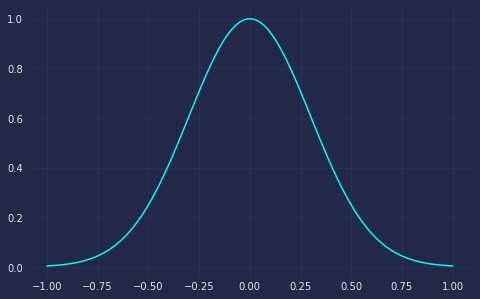

In [13]:
x = np.linspace(-1, 1, N)
y = gauss(x, 0.3)
plt.plot(x, y)


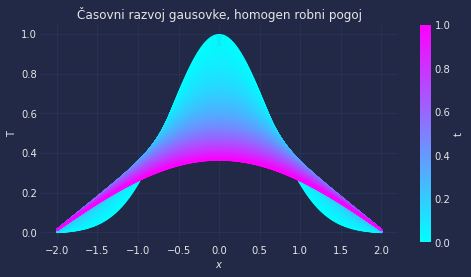

In [16]:
N = 100

x = np.linspace(-2, 2,N)
delta_x = x[1] - x[0]
D = 1

A = np.fromfunction(np.vectorize(A_ij), (N, N))
B = 6*D/delta_x**2 * np.fromfunction(np.vectorize(B_ij), (N, N))

X = np.linspace(-1, 1, N)
Y_z = gauss(X, 0.3)
Y_z -= Y_z[0]

M = 500
t = np.linspace(0, 1, M)

A_inv_B = np.dot(np.linalg.inv(A), B)

T_t = odeint(lambda y, t: np.dot(A_inv_B, y), Y_z, t)
# plt.plot(x, Y_t[-1])

cmap = plt.get_cmap('cool', len(T_t))
fig, axes = plt.subplots(ncols=1, figsize=(8, 4))
ax0 = axes

for i in range(len(T_t)):
    plt.plot(x, (T_t[i]), c=cmap(i))
norm = mpl.colors.Normalize(vmin=t[0], vmax=t[-1])
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.xlabel(r'$x$')
plt.ylabel('T')
plt.title("Časovni razvoj gausovke, homogen robni pogoj")
fig.colorbar(sm, ax=axes, label=r't')

plt.savefig("./grafi/periodicni_kolokacijska.pdf", bbox_inches='tight')

# mplcyberpunk.make_lines_glow()
plt.show()
